# Regularized Linear Regression and Bias-Variance

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io
import scipy.optimize as op

In [2]:
mat = scipy.io.loadmat('ex5/ex5data1.mat')
X = mat['X']
y = mat['y']
X_val = mat['Xval']
y_val = mat['yval']
X_test = mat['Xtest']
y_test = mat['ytest']

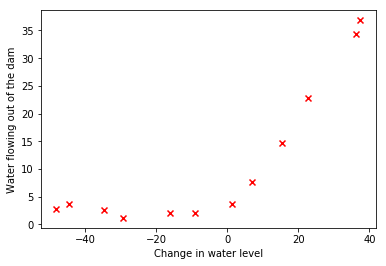

In [3]:
fig, ax = plt.subplots()

ax.set_xlabel('Change in water level')
ax.set_ylabel('Water flowing out of the dam')

ax.scatter(X, y, marker='x', c='red')

plt.show()

In [4]:
def linreg_cost(theta, X, y, λ, regularized=True):
    m = X.shape[0]
    
    theta_reg = np.copy(theta)
    theta_reg[0] = 0
    
    prediction = np.dot(np.column_stack((np.ones(m), X)), theta)
    # ensure column vector
    if prediction.ndim == 1:
        prediction = np.expand_dims(prediction, axis=1)

    error = prediction - y
    cost = 1. / (2 * m) * np.sum(np.square(error))
    
    if regularized:
        penalty = λ / (2 * m) * np.sum(np.square(theta_reg))
        cost += penalty
    
    return cost

In [5]:
theta = np.ones((2, 1))
cost = linreg_cost(theta, X, y, λ=1, regularized=True)
print('cost at theta = [1, 1]:', cost)

cost at theta = [1, 1]: 303.99319222


In [6]:
def linreg_grad(theta, X, y, λ, regularized=True):
    m = X.shape[0]
    
    theta_reg = np.copy(theta)
    theta_reg[0] = 0
    
    prediction = np.dot(np.column_stack((np.ones(m), X)), theta)
    # ensure column vector
    if prediction.ndim == 1:
        prediction = np.expand_dims(prediction, axis=1)
    
    error = prediction - y
    grad = 1 / m * np.dot(error.T, np.column_stack((np.ones(m), X))) 
    
    if regularized:
        penalty = theta_reg.T * λ / m
        grad += penalty
    
    return grad.flatten()

In [7]:
grad = linreg_grad(theta, X, y, λ=1, regularized=True)
print('gradient at theta = [1, 1]:', grad)

gradient at theta = [1, 1]: [ -15.30301567  598.25074417]


In [8]:
def train_linreg(X, y, cost_fn, grad_fn, λ, epsilon=0.01):
    initial_theta = np.random.uniform(-epsilon, epsilon, size=(X.shape[1] + 1, 1))
    return op.minimize(
        fun=cost_fn, 
        x0=initial_theta, 
        args=(X, y, λ),
        options={'disp': False, 'maxiter':200}, 
        method="BFGS",
        jac=grad_fn).x

In [9]:
theta_train = train_linreg(X, y, linreg_cost, linreg_grad, λ=1)
print('theta after training (w/ regularization):', theta_train)

theta after training (w/ regularization): [ 13.08771416   0.367742  ]


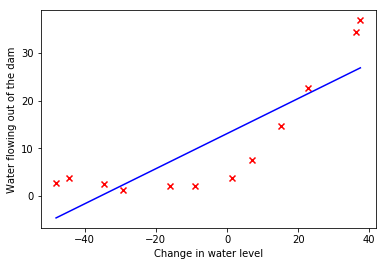

In [10]:
fig, ax = plt.subplots()

ax.set_xlabel('Change in water level')
ax.set_ylabel('Water flowing out of the dam')

x_min = np.min(X)
x_max = np.max(X)
y_min = theta_train[0] + theta_train[1] * x_min
y_max = np.max(np.dot(np.column_stack((np.ones(X.shape[0]), X)), theta_train))

ax.scatter(X, y, marker='x', c='red')
ax.plot([x_min, x_max], [y_min, y_max], c='b')    

plt.show()

In [11]:
m = X.shape[0]
error_train = np.zeros(m)
error_val = np.zeros(m)

# train on increasing subset of data
for i in range(1, m + 1):
    X_train = X[:i, :]
    y_train = y[:i, :]
    
    train_theta = train_linreg(X_train, y_train, linreg_cost, linreg_grad, λ=0)
    error_train[i - 1] = linreg_cost(train_theta, X_train, y_train, λ=0)
    error_val[i - 1] = linreg_cost(train_theta, X_val, y_val, λ=0)

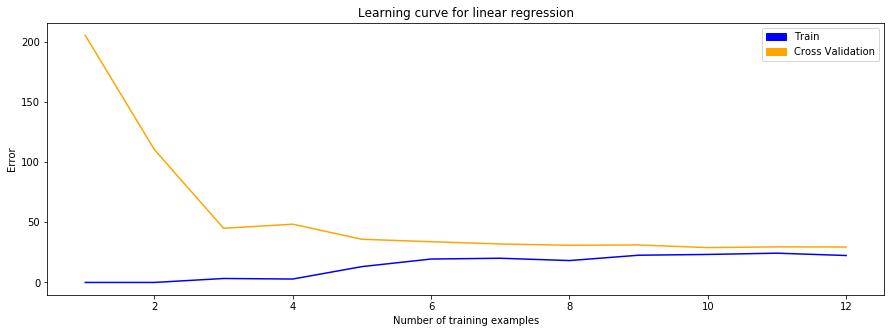

In [45]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Learning curve for linear regression')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error')

train_plot = ax.plot(np.arange(1, m + 1), error_train, color='blue')
val_plot = ax.plot(np.arange(1, m + 1), error_val, color='orange')

train_patch = mpatches.Patch(color='blue', label='Train')
val_patch = mpatches.Patch(color='orange', label='Cross Validation')
plt.legend(handles=[train_patch, val_patch])

plt.show()

In [46]:
def make_polynomial(X, degree):
    Xout = np.copy(X)
    for i in range(2, degree + 1):
        Xout = np.hstack((Xout, np.power(X, i)))
    return Xout

In [47]:
def normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_norm = (X - X_mean) / X_std
    return X_norm

In [48]:
Xpoly = normalize(make_polynomial(X, 8))
Xpoly_test = normalize(make_polynomial(X_test, 8))
Xpoly_val = normalize(make_polynomial(X_val, 8))

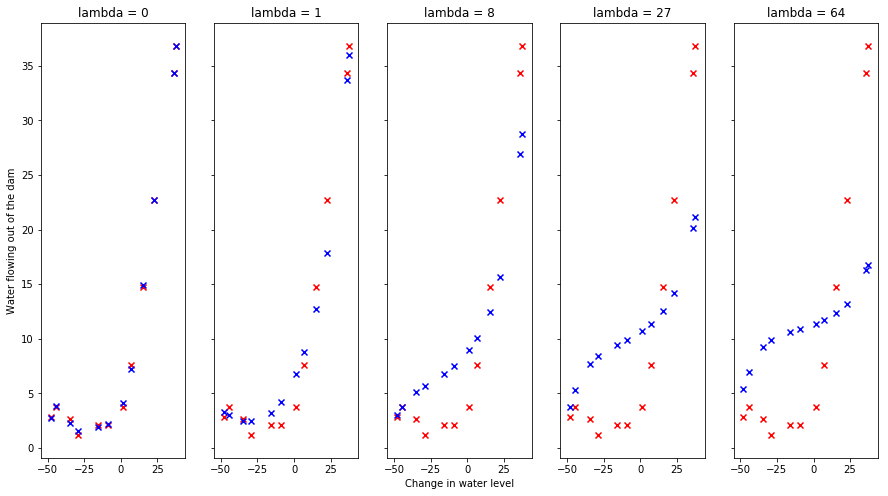

In [49]:
m, n = Xpoly.shape
fig, axes = plt.subplots(ncols=5, figsize=(15, 8), sharey=True, sharex=True)

axes[0].set_ylabel('Water flowing out of the dam')
axes[2].set_xlabel('Change in water level')

for i in range(5):
    λ = i**3
    theta_train = train_linreg(Xpoly, y, linreg_cost, linreg_grad, λ)
    ax = axes[i]
    ax.set_title('lambda = {}'.format(λ))

    ax.scatter(X, y, marker='x', c='red')
    ax.scatter(X, np.dot(np.column_stack((np.ones(m), Xpoly)), 
                         np.expand_dims(theta_train, axis=1)), 
               marker='x', c='blue')

plt.show()

In [51]:
λ = 0
m = Xpoly.shape[0]
error_train = np.zeros(m)
error_val   = np.zeros(m)

for i in range(1, m + 1):
    Xpoly_train = Xpoly[:i, :]
    y_train = y[:i, :]

    train_theta = train_linreg(Xpoly_train, y_train, linreg_cost, linreg_grad, λ)
    error_train[i - 1] = linreg_cost(train_theta, Xpoly_train, y_train, λ)
    error_val[i - 1] = linreg_cost(train_theta, Xpoly_val, y_val, λ)

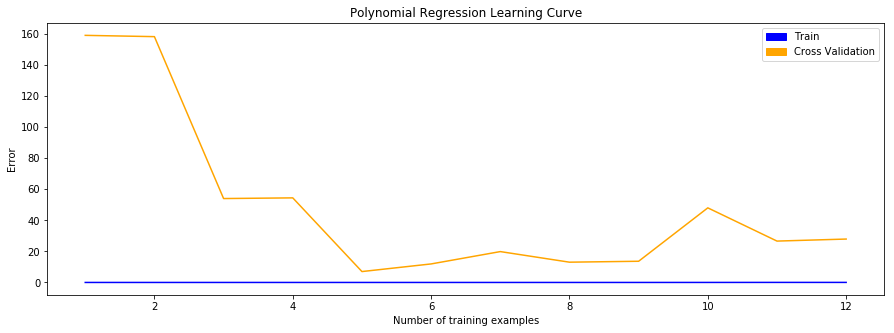

In [52]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Polynomial Regression Learning Curve')
ax.set_xlabel('Number of training examples')
ax.set_ylabel('Error')

train_poly_plot = ax.plot(np.arange(1, m + 1), error_train, color='blue')
val_poly_plot = ax.plot(np.arange(1, m + 1), error_val, color='orange')

train_patch = mpatches.Patch(color='blue', label='Train')
val_patch = mpatches.Patch(color='orange', label='Cross Validation')
plt.legend(handles=[train_patch, val_patch])

plt.show()

In [67]:
lambda_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

m = len(lambda_vec)
error_train = [0] * m
error_val = [0] * m

for i in range(m):
    train_theta = train_linreg(Xpoly, y, linreg_cost, linreg_grad, lambda_vec[i])
    error_train[i] = linreg_cost(train_theta, Xpoly, y, lambda_vec[i])
    error_val[i] = linreg_cost(train_theta, Xpoly_val, y_val, lambda_vec[i])

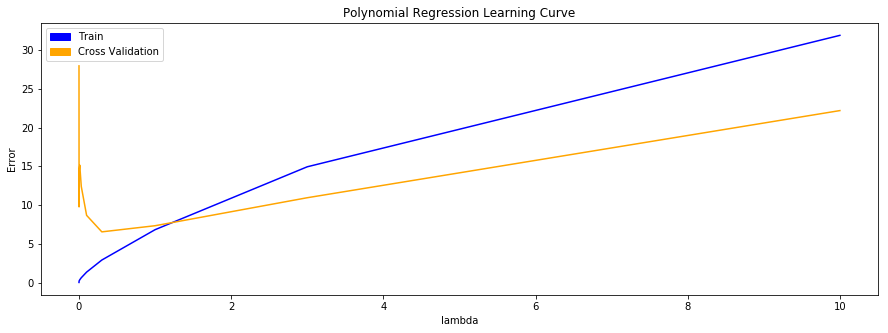

In [68]:
fig, ax = plt.subplots(figsize=(15, 5))

ax.set_title('Polynomial Regression Learning Curve')
ax.set_xlabel('lambda')
ax.set_ylabel('Error')

ax.plot(lambda_vec, error_train, color='blue')
ax.plot(lambda_vec, error_val, color='orange')

train_patch = mpatches.Patch(color='blue', label='Train')
val_patch = mpatches.Patch(color='orange', label='Cross Validation')
plt.legend(handles=[train_patch, val_patch])

plt.show()